# Evil Geniuses Data Analyst Case

In [2]:
import os
os.chdir("C:\case")
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress
import statsmodels.api as sm
import calendar

## The Main Dataset

The main dataset contains data about every posts on the Twitter from January 1, 2020 until December 16, 2020. Let me give you a brief walkthrough of the kind of data available so as to give you an idea of what are the possibilities with this dataset.

In [1]:
ptad = pd.read_csv('C:/case/PostTypeAnalysisDateset.csv', parse_dates=['post_date'])
ptad.info()

NameError: name 'pd' is not defined

* **post_date** – the date the post was tweeted
* **entity_id** – the unique identifier of the account that sent the tweet
* **followers** – the number of followers the account had on the day of the post
* **picture** – true if post contained a picture
* **video** – true if post contained a video 
* **video_duration_secs** – length of the video in seconds
* **impressions** – the number of impressions the post received
* **likes** – number of likes the post received
* **shares** – number of shares the post received
* **replies** – number of replies the post received
* **engagement_rate** – number of engagements post received / follower count


## Data Cleaning 

**1.** Lets first introduce dummy variables, so that we can work with them in our regression models

In [3]:
ptad['dummy_picture'] = np.where(ptad['is_picture'] == True, 1,0)
ptad['dummy_video'] = np.where(ptad['is_video'] == True, 1,0)
ptad['dummy_text'] = np.where((ptad['is_video'] == False) & (ptad['is_picture'] == False), 1,0)
ptad['twit_type'] = np.where((ptad['is_video'] == False) & (ptad['is_picture'] == False), 1,0)


#creating new collumn for a twit type
conditions = [
    (ptad['is_video'] == True),
    (ptad['is_picture'] == True),
    (ptad['dummy_text'] == 1 )
    ]

# create a list of the values we want to assign for each condition
values = ['Video', 'Picture', 'Text']

# create a new column and use np.select to assign values to it using our lists as arguments
ptad['twit_type'] = np.select(conditions, values)


**2.** Lets remove duplicates and null values. 

In [4]:
#now we will convert post_date collumn to a datetime 
ptad['post_date'] = pd.to_datetime(ptad['post_date'])
ptad['hour'] = ptad['post_date'].dt.hour
ptad['date'] = ptad['post_date'].dt.date

ptad['date'] = pd.to_datetime(ptad['date'])

#lets find out which day of the week our dates are
#first lets run dayofweek function
#it will give days based on number of the day
#The day of the week with Monday=0, Sunday=6.
ptad['day_of_week']=ptad['date'].dt.dayofweek

condition0 = [
    (ptad['day_of_week'] == 0),
    (ptad['day_of_week'] == 1),
    (ptad['day_of_week'] == 2),
    (ptad['day_of_week'] == 3),
    (ptad['day_of_week'] == 4),
    (ptad['day_of_week'] == 5),
    (ptad['day_of_week'] == 6),
]

# create a list of the values we want to assign for each condition
values0 = ['Monday', 'Tuesday', 'Wedenesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# create a new column and use np.select to assign values to it using our lists as arguments
ptad['day_of_the_week'] = np.select(condition0, values0)


#now we are working on assigning period of the day - morning, afternoon, evening, night
#creating new collumn for a time of the day
conditions1 = [
    (ptad['hour'] <= 6),
    (ptad['hour'] <= 12),
    (ptad['hour'] <= 18),
    (ptad['hour'] <= 24)
    ]


#0-6 Night
#6-12 Morning
#12-18 Afternoon
#18-24 Evening
# create a list of the values we want to assign for each condition
values1 = ['Night', 'Morning', 'Afternoon', 'Evening']

# create a new column and use np.select to assign values to it using our lists as arguments
ptad['time_of_day'] = np.select(conditions1, values1)


#changing ccollumns
ptad = ptad[['post_date', 'date', 'hour', 'day_of_week','day_of_the_week','time_of_day', 'entity_id', 'twit_type', 'followers','is_picture',
            'is_video', 'video_duration_secs', 'impressions', 'likes', 'shares', 
            'replies', 'engagement_rate', 'dummy_picture', 'dummy_video', 'dummy_text']]

In [5]:
#checking missing data
mis= ptad['followers'].isna().sum()
sum = len(ptad['followers'])
mis1= ptad['video_duration_secs'].isna().sum()
sum1 = len(ptad['video_duration_secs'])
total_miss_perc = mis/sum 
total_miss_perc1 = mis1/sum1
print("Total missing followers data is:",total_miss_perc)
print("Total missing video duration data is:",total_miss_perc1)
print(ptad.isna().sum())

Total missing followers data is: 0.0009246417013407304
Total missing video duration data is: 0.8686348325738062
post_date                  0
date                       0
hour                       0
day_of_week                0
day_of_the_week            0
time_of_day                0
entity_id                  0
twit_type                  0
followers                 14
is_picture                 0
is_video                   0
video_duration_secs    13152
impressions               14
likes                      0
shares                     0
replies                    0
engagement_rate            0
dummy_picture              0
dummy_video                0
dummy_text                 0
dtype: int64


Total **missing percentage** of followers and impressions collumn is lower than **1%**, so we can delete those missing values, hence there is no influence of them on our overall data 

In [6]:
ptad = ptad.dropna(subset=['followers'])

**3.** Lets sort out text data, video data, and photo data

In [7]:
#photo data 
picture = ptad[ptad['dummy_picture'] == 1]
#video data 
video = ptad[ptad['dummy_video'] == 1]
#text  data
text = ptad[ptad['dummy_text'] == 1]
print("Summary for picture dataset", picture.info())
ptad

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4684 entries, 6 to 15138
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   post_date            4684 non-null   datetime64[ns]
 1   date                 4684 non-null   datetime64[ns]
 2   hour                 4684 non-null   int64         
 3   day_of_week          4684 non-null   int64         
 4   day_of_the_week      4684 non-null   object        
 5   time_of_day          4684 non-null   object        
 6   entity_id            4684 non-null   object        
 7   twit_type            4684 non-null   object        
 8   followers            4684 non-null   float64       
 9   is_picture           4684 non-null   bool          
 10  is_video             4684 non-null   bool          
 11  video_duration_secs  0 non-null      float64       
 12  impressions          4684 non-null   float64       
 13  likes                4684 non-nu

,post_date,date,hour,day_of_week,day_of_the_week,time_of_day,entity_id,twit_type,followers,is_picture,is_video,video_duration_secs,impressions,likes,shares,replies,engagement_rate,dummy_picture,dummy_video,dummy_text
0,2020-01-02 17:10:00,2020-01-02,17,3,Thursday,Afternoon,7AD030340F434EECA5B4FC28034E1113,Text,242458.0,False,False,NaN,3.602337e+04,123,3,42,0.000693,0,0,1
1,2020-01-02 17:46:00,2020-01-02,17,3,Thursday,Afternoon,7AD030340F434EECA5B4FC28034E1113,Text,242458.0,False,False,NaN,2.340268e+04,4,0,0,0.000017,0,0,1
2,2020-10-09 16:06:00,2020-10-09,16,4,Friday,Afternoon,4AAFEFB838974FDCA41932C4D32FD52A,Text,2102820.0,False,False,NaN,2.046399e+05,24,1,2,0.000013,0,0,1
3,2020-10-09 16:08:00,2020-10-09,16,4,Friday,Afternoon,4AAFEFB838974FDCA41932C4D32FD52A,Text,2102820.0,False,False,NaN,2.088727e+05,91,1,2,0.000045,0,0,1
4,2020-10-10 13:00:00,2020-10-10,13,5,Saturday,Afternoon,4A3372EBDC9C484AA8503A96CD14B858,Text,1023570.0,False,False,NaN,1.360206e+05,465,9,2,0.000465,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15136,2020-12-15 21:13:00,2020-12-15,21,1,Tuesday,Evening,4A3372EBDC9C484AA8503A96CD14B858,Video,1066898.0,False,True,18.933,1.422884e+05,468,11,14,0.000462,0,1,0
15137,2020-12-15 21:14:00,2020-12-15,21,1,Tuesday,Evening,4A3372EBDC9C484AA8503A96CD14B858,Picture,1066898.0,True,False,NaN,1.030436e+05,33,0,0,0.000031,1,0,0
15138,2020-12-15 17:15:00,2020-12-15,17,1,Tuesday,Afternoon,734CC11FE5EC4290A623F16482B387FF,Picture,5149433.0,True,False,NaN,1.149842e+06,11429,116,1366,0.002507,1,0,0
15139,2020-12-15 21:53:00,2020-12-15,21,1,Tuesday,Evening,734CC11FE5EC4290A623F16482B387FF,Video,5149433.0,False,True,26.001,6.061280e+05,1604,23,33,0.000322,0,1,0


## Most impressed/liked/shared/replied tweets of All Time

For starters, let us perform some easy analysis. I want to know what the 10 most viewed, liked and shared Twits of all time are. The number of views gives us a good idea of the popularity of the Twit.


In [8]:
#sorted by impressions/views
pop_twits = ptad[['twit_type', 'entity_id', 'impressions', 'likes', 'shares', 'replies', 'date']].sort_values('impressions', ascending=False)[:15]
pop_twits

,twit_type,entity_id,impressions,likes,shares,replies,date
1812,Picture,4A3372EBDC9C484AA8503A96CD14B858,4917791.883,119365,1733,2472,2020-09-16
11665,Picture,734CC11FE5EC4290A623F16482B387FF,4838168.329,91956,8228,2043,2020-08-30
11431,Picture,734CC11FE5EC4290A623F16482B387FF,4183208.228,91095,19719,1388,2020-06-18
14550,Picture,40B1ADC3F6F54143BACCB3D8FB000756,3912901.023,85767,4354,929,2020-12-11
11189,Text,734CC11FE5EC4290A623F16482B387FF,3767479.548,68360,6778,65836,2020-04-01
5295,Picture,4A3372EBDC9C484AA8503A96CD14B858,3554295.671,29047,14882,26,2020-09-01
8319,Picture,4A3372EBDC9C484AA8503A96CD14B858,2603098.037,56321,2169,245,2020-06-16
11094,Picture,734CC11FE5EC4290A623F16482B387FF,2570045.305,42250,3052,2658,2020-02-29
13530,Picture,734CC11FE5EC4290A623F16482B387FF,2563491.498,40332,1945,749,2020-11-18
11404,Text,734CC11FE5EC4290A623F16482B387FF,2483190.358,39051,1472,33496,2020-06-08


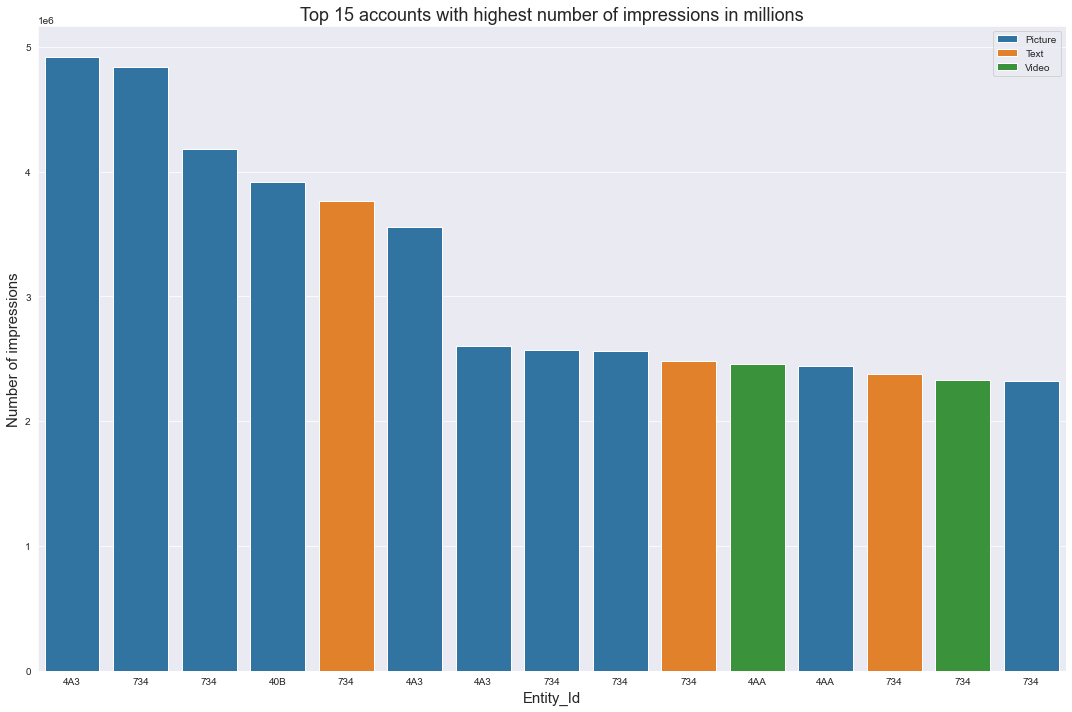

In [9]:
bp = pop_twits.sort_values('impressions', ascending=False)
bp['acc_id'] = bp['entity_id'].apply(lambda x: x[:3])
sns.set_style('darkgrid')
plt.figure(figsize=(15,10))
ax = sns.barplot(x=bp.index, y='impressions',hue = 'twit_type', dodge=False, data=bp,
                order=bp.sort_values('impressions', ascending = False).index)
ax.set_xticklabels(bp['acc_id'])

plt.xlabel("Entity_Id", size=15)
plt.ylabel("Number of impressions", size=15)
plt.title("Top 15 accounts with highest number of impressions in millions", size=18)
plt.tight_layout()
plt.legend(loc='upper right')

In [10]:
#sorted by likes
pop_twits1 = ptad[['twit_type', 'entity_id', 'impressions', 'likes', 'shares', 'replies', 'date']].sort_values('likes', ascending=False)[:15]
pop_twits1

,twit_type,entity_id,impressions,likes,shares,replies,date
1812,Picture,4A3372EBDC9C484AA8503A96CD14B858,4.917792e+06,119365,1733,2472,2020-09-16
11665,Picture,734CC11FE5EC4290A623F16482B387FF,4.838168e+06,91956,8228,2043,2020-08-30
11431,Picture,734CC11FE5EC4290A623F16482B387FF,4.183208e+06,91095,19719,1388,2020-06-18
14550,Picture,40B1ADC3F6F54143BACCB3D8FB000756,3.912901e+06,85767,4354,929,2020-12-11
11189,Text,734CC11FE5EC4290A623F16482B387FF,3.767480e+06,68360,6778,65836,2020-04-01
8319,Picture,4A3372EBDC9C484AA8503A96CD14B858,2.603098e+06,56321,2169,245,2020-06-16
1702,Picture,40B1ADC3F6F54143BACCB3D8FB000756,2.119694e+06,46130,2544,1922,2020-07-10
11647,Picture,734CC11FE5EC4290A623F16482B387FF,9.677761e+05,43087,26771,21816,2020-08-28
11094,Picture,734CC11FE5EC4290A623F16482B387FF,2.570045e+06,42250,3052,2658,2020-02-29
13530,Picture,734CC11FE5EC4290A623F16482B387FF,2.563491e+06,40332,1945,749,2020-11-18


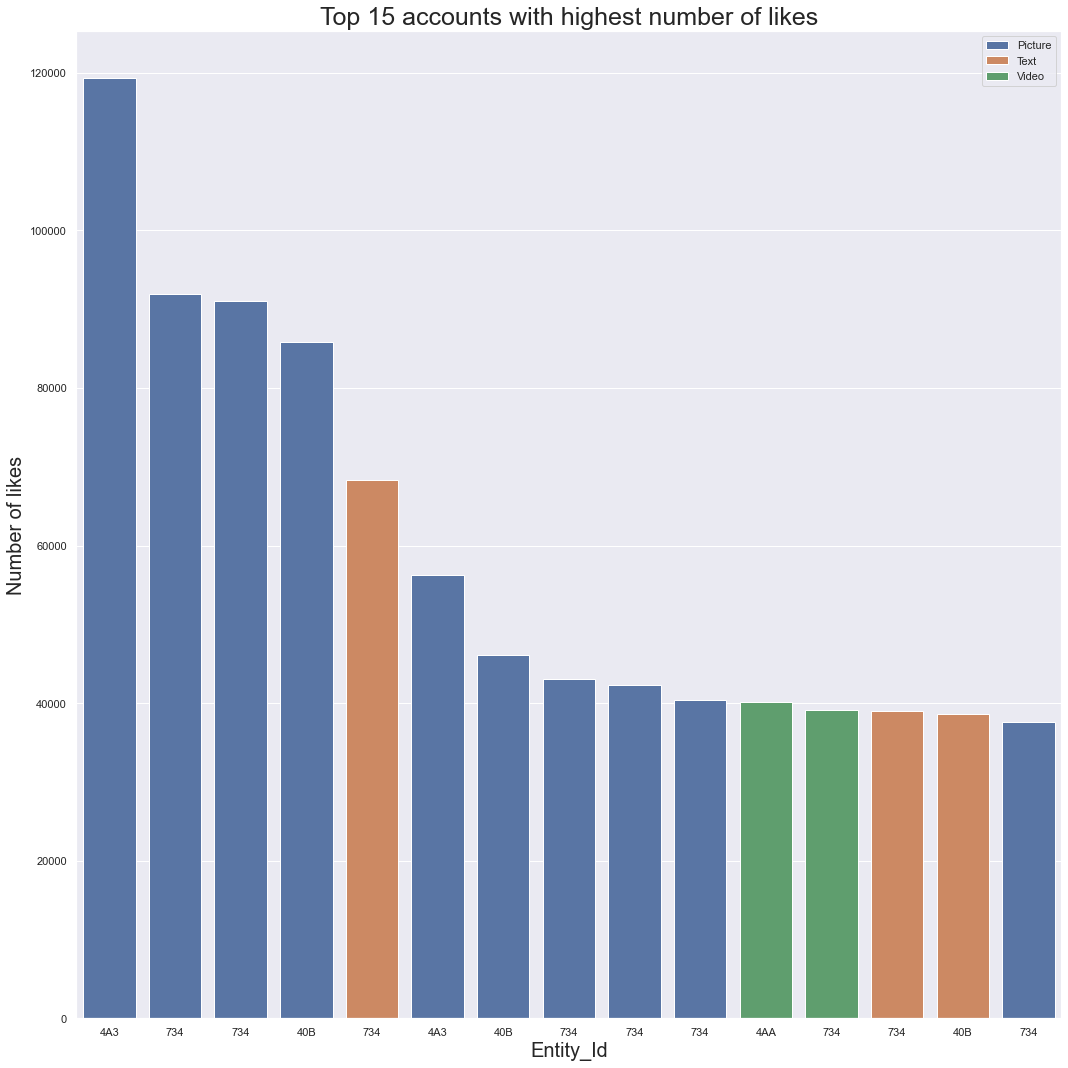

In [43]:
bp1 = pop_twits1.sort_values('likes', ascending=False)
bp1['acc_id'] = bp1['entity_id'].apply(lambda x: x[:3])
sns.set_style('darkgrid')
plt.figure(figsize=(15,15))
ax = sns.barplot(x=bp1.index, y='likes', hue = 'twit_type',dodge=False, data=bp1,
                order=bp1.sort_values('likes', ascending = False).index)
ax.set_xticklabels(bp1['acc_id'])

plt.xlabel("Entity_Id", size=20)
plt.ylabel("Number of likes", size=20)
plt.title("Top 15 accounts with highest number of likes", size=25)
plt.tight_layout()
plt.legend(loc='upper right')

In [12]:
#sorted by shares
ptad
pop_twits2 = ptad[['twit_type', 'entity_id', 'impressions', 'likes', 'shares', 'replies', 'date']].sort_values('shares', ascending=False)[:15]
pop_twits2

,twit_type,entity_id,impressions,likes,shares,replies,date
11647,Picture,734CC11FE5EC4290A623F16482B387FF,9.677761e+05,43087,26771,21816,2020-08-28
11431,Picture,734CC11FE5EC4290A623F16482B387FF,4.183208e+06,91095,19719,1388,2020-06-18
5295,Picture,4A3372EBDC9C484AA8503A96CD14B858,3.554296e+06,29047,14882,26,2020-09-01
11665,Picture,734CC11FE5EC4290A623F16482B387FF,4.838168e+06,91956,8228,2043,2020-08-30
4867,Picture,4AAFEFB838974FDCA41932C4D32FD52A,1.256136e+06,7555,7122,0,2020-09-23
7743,Picture,4AAFEFB838974FDCA41932C4D32FD52A,1.082547e+06,3786,7008,302,2020-07-10
11189,Text,734CC11FE5EC4290A623F16482B387FF,3.767480e+06,68360,6778,65836,2020-04-01
8016,Picture,4AAFEFB838974FDCA41932C4D32FD52A,1.067369e+06,5045,6234,65,2020-08-30
12804,Text,4A3372EBDC9C484AA8503A96CD14B858,1.736890e+06,18056,5687,186,2020-10-02
14937,Picture,734CC11FE5EC4290A623F16482B387FF,3.624131e+05,5423,5576,919,2020-12-11


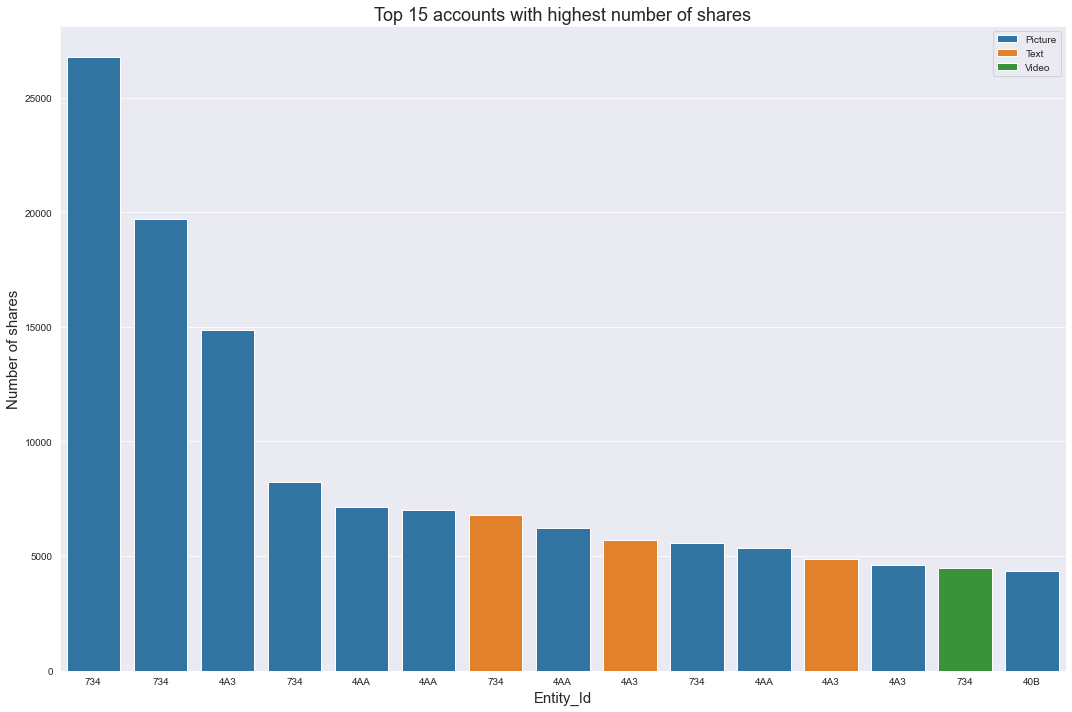

In [13]:
bp2 = pop_twits2.sort_values('shares', ascending=False)
bp2['acc_id'] = bp2['entity_id'].apply(lambda x: x[:3])
sns.set_style('darkgrid')
plt.figure(figsize=(15,10))
ax = sns.barplot(x=bp2.index, y='shares', dodge=False, hue = 'twit_type', data=bp2,
                order=bp2.sort_values('shares', ascending = False).index)
ax.set_xticklabels(bp2['acc_id'])

plt.xlabel("Entity_Id", size=15)
plt.ylabel("Number of shares", size=15)
plt.title("Top 15 accounts with highest number of shares", size=18)
plt.tight_layout()
plt.legend(loc='upper right')

In [14]:
#sorted by replies
pop_twits3 = ptad[['twit_type', 'entity_id', 'impressions', 'likes', 'shares', 'replies', 'date']].sort_values('replies', ascending=False)[:15]
pop_twits3

,twit_type,entity_id,impressions,likes,shares,replies,date
11189,Text,734CC11FE5EC4290A623F16482B387FF,3.767480e+06,68360,6778,65836,2020-04-01
11404,Text,734CC11FE5EC4290A623F16482B387FF,2.483190e+06,39051,1472,33496,2020-06-08
11463,Text,734CC11FE5EC4290A623F16482B387FF,1.694195e+06,23226,731,23963,2020-06-28
11647,Picture,734CC11FE5EC4290A623F16482B387FF,9.677761e+05,43087,26771,21816,2020-08-28
11365,Picture,734CC11FE5EC4290A623F16482B387FF,1.122160e+06,14190,2705,15839,2020-05-22
4781,Text,734CC11FE5EC4290A623F16482B387FF,1.871679e+06,25983,711,12694,2020-09-19
10962,Text,734CC11FE5EC4290A623F16482B387FF,2.374060e+06,37513,1554,10001,2020-01-01
13184,Text,734CC11FE5EC4290A623F16482B387FF,1.194649e+06,13056,701,9658,2020-10-25
11331,Picture,734CC11FE5EC4290A623F16482B387FF,1.402041e+06,17811,443,9227,2020-05-14
14871,Text,734CC11FE5EC4290A623F16482B387FF,1.549869e+06,18904,130,9178,2020-12-10


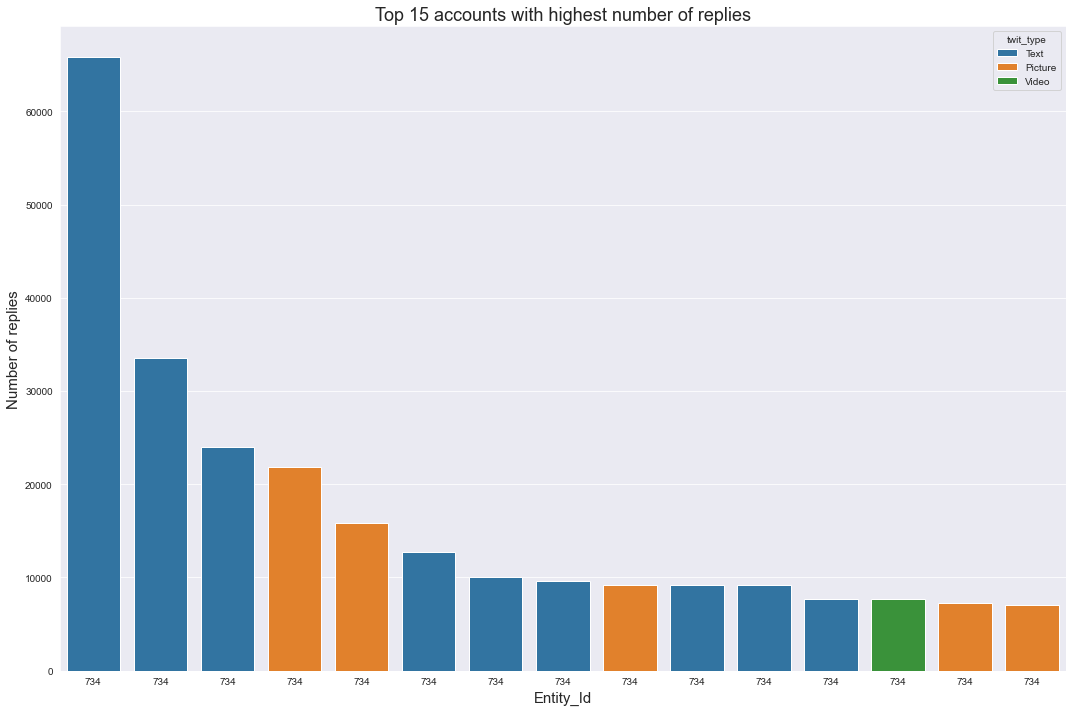

In [15]:
bp3 = pop_twits3.sort_values('replies', ascending=False)
bp3['acc_id'] = bp3['entity_id'].apply(lambda x: x[:3])
sns.set_style('darkgrid')
plt.figure(figsize=(15,10))
ax3 = sns.barplot(x=bp3.index, y='replies', hue = 'twit_type',dodge=False, data=bp3,
                order=bp3.sort_values('replies', ascending = False).index)
ax3.set_xticklabels(bp3['acc_id'])

plt.xlabel("Entity_Id", size=15)
plt.ylabel("Number of replies", size=15)
plt.title("Top 15 accounts with highest number of replies", size=18)
plt.tight_layout()

In [16]:
#sorted by engagement rate
pop_twits3 = ptad[['twit_type', 'entity_id', 'impressions', 'likes', 'shares', 'date', 'engagement_rate']].sort_values('engagement_rate', ascending=False)[:15]
pop_twits3

,twit_type,entity_id,impressions,likes,shares,date,engagement_rate
1812,Picture,4A3372EBDC9C484AA8503A96CD14B858,4.917792e+06,119365,1733,2020-09-16,0.124206
14550,Picture,40B1ADC3F6F54143BACCB3D8FB000756,3.912901e+06,85767,4354,2020-12-11,0.115096
1702,Picture,40B1ADC3F6F54143BACCB3D8FB000756,2.119694e+06,46130,2544,2020-07-10,0.081174
1024,Picture,40B1ADC3F6F54143BACCB3D8FB000756,1.715712e+06,32123,3174,2020-01-22,0.071534
1598,Text,40B1ADC3F6F54143BACCB3D8FB000756,1.704144e+06,38589,1683,2020-06-13,0.067706
8319,Picture,4A3372EBDC9C484AA8503A96CD14B858,2.603098e+06,56321,2169,2020-06-16,0.062521
1128,Video,40B1ADC3F6F54143BACCB3D8FB000756,1.410363e+06,27473,2244,2020-02-20,0.057902
1567,Picture,40B1ADC3F6F54143BACCB3D8FB000756,1.647420e+06,29724,3001,2020-05-31,0.055768
1571,Video,40B1ADC3F6F54143BACCB3D8FB000756,1.420887e+06,25217,2548,2020-06-04,0.047792
1611,Picture,40B1ADC3F6F54143BACCB3D8FB000756,1.294765e+06,25531,1765,2020-06-19,0.045768


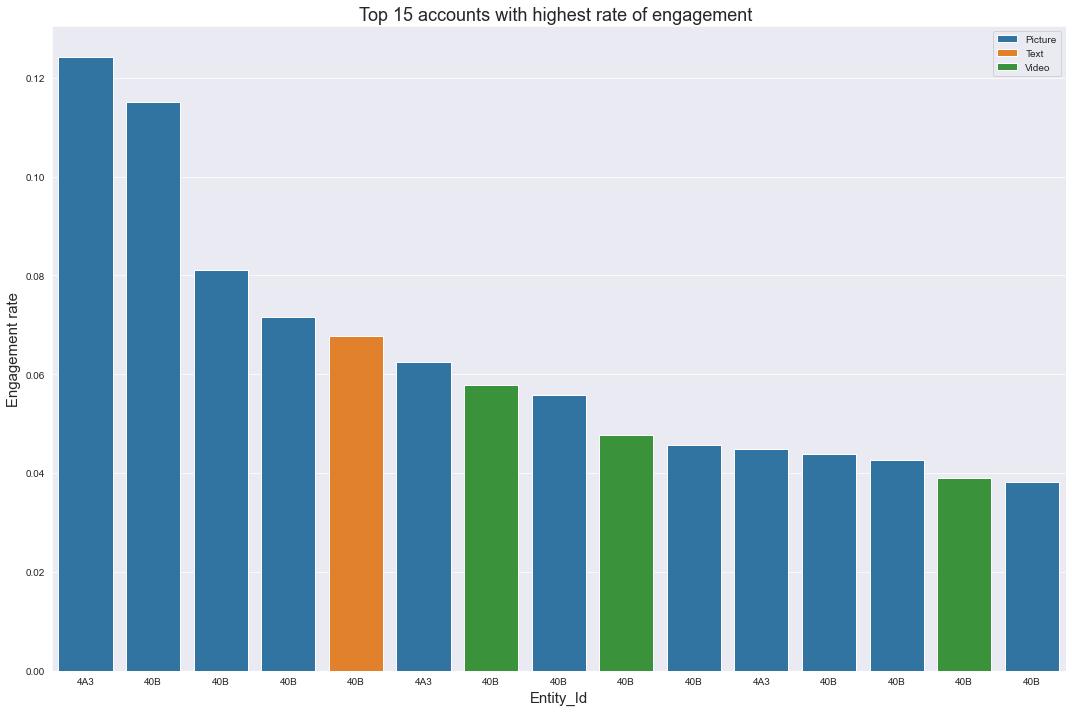

In [17]:
bp3 = pop_twits3.sort_values('engagement_rate', ascending=False)
bp3['acc_id'] = bp3['entity_id'].apply(lambda x: x[:3])
sns.set_style('darkgrid')
plt.figure(figsize=(15,10))
ax3 = sns.barplot(x=bp3.index, y='engagement_rate', hue = 'twit_type',dodge=False, data=bp3,
                order=bp3.sort_values('engagement_rate', ascending = False).index)
ax3.set_xticklabels(bp3['acc_id'])

plt.xlabel("Entity_Id", size=15)
plt.ylabel("Engagement rate", size=15)
plt.title("Top 15 accounts with highest rate of engagement ", size=18)
plt.tight_layout()
plt.legend(loc='upper right')

##### Observations

* 9 out of 10 most viewed tweets are pictures with highest tweet accounting for 4 mln 900 thousand views.
* Account **4A3372EBDC9C484AA8503A96CD14B858** has most views and most likes according
* Only 3 accounts such **4A3372EBDC9C484AA8503A96CD14B858**, **734CC11FE5EC4290A623F16482B387FF**, **40B1ADC3F6F54143BACCB3D8FB000756** are occured on our top viewed, liked list
* Moreover, if we look at replies only account **734CC11FE5EC4290A623F16482B387FF** has appeared on top 10 list
* On most replied list,  7 out of 10 twits are text twits
* We don't have videos in our list top 10 list 

Finally, in this section, let us investigate the summary statistics and the distibution of the views/likes/shares/replies garnered on various twits depending on the type of video (photo, text, video).

## Summary statistics and distribution of the data

### Impressions

In [5]:
print('Impressions statistics for pictures:')
print(round(picture['impressions'].describe()))
print('--------------------------------------')
print('Impressions statistics for videos:')
print(round(video['impressions'].describe()))
print('--------------------------------------')
print('Impressions statistics for texts:')
print(round(text['impressions'].describe()))

plt.figure(figsize=(15,10))
sns.set_style('whitegrid')
sns.histplot(data = ptad, x="impressions", hue="twit_type", element="step")
plt.xlim(0, 300000)

plt.xlabel("Number of views", size=15)
plt.ylabel("Count", size=15)
plt.title("Distribution of impressions based on tweet type", size=18)

plt.axvline(x=video.impressions.median(),
            color='green',linestyle='--')
plt.axvline(x=picture.impressions.median(),
            color='orange',linestyle='--')
plt.axvline(x=text.impressions.median(),
            color='blue',linestyle='--')
plt.legend(title='Tweet type', loc='upper right', labels=['Video', 'Picture', 'Text', 
                                                          'Median line for video', 'Median line for picture', 'Median line for text'])

Impressions statistics for pictures:


NameError: name 'picture' is not defined

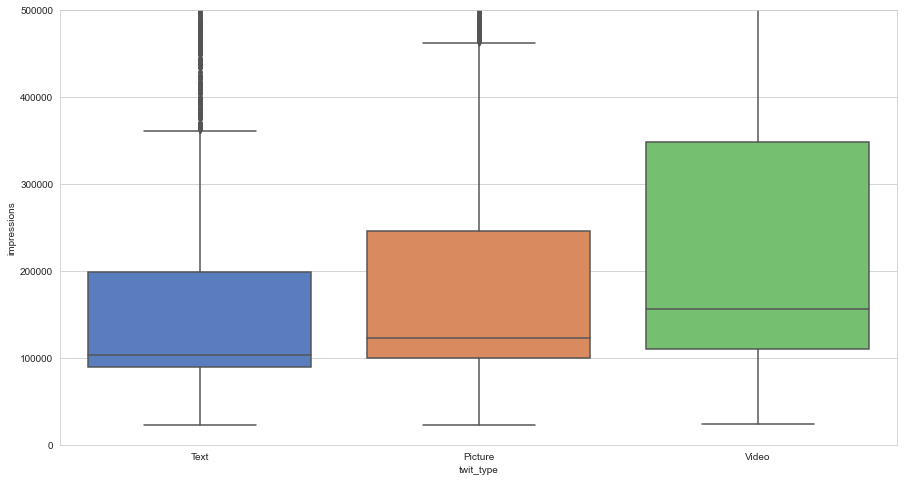

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 8))
sns.boxplot(x='twit_type', y='impressions', data=ptad[ptad['twit_type'].isin(ptad['twit_type'])], palette="muted", ax =ax)
ax.set_ylim([0, 500000])
plt.show()

### Likes

Likes statistics for pictures:
count     4684.0000
mean      1694.0000
std       4625.0000
min          0.0000
25%         70.0000
50%        265.0000
75%       1432.0000
max     119365.0000
Name: likes, dtype: float64
--------------------------------------
Likes statistics for videos:
count    1987.0000
mean     1987.0000
std      3480.0000
min         0.0000
25%       174.0000
50%       691.0000
75%      2376.0000
max     40184.0000
Name: likes, dtype: float64
--------------------------------------
Likes statistics for texts:
count    8456.0000
mean      719.0000
std      2343.0000
min         0.0000
25%        10.0000
50%        87.0000
75%       437.0000
max     68360.0000
Name: likes, dtype: float64


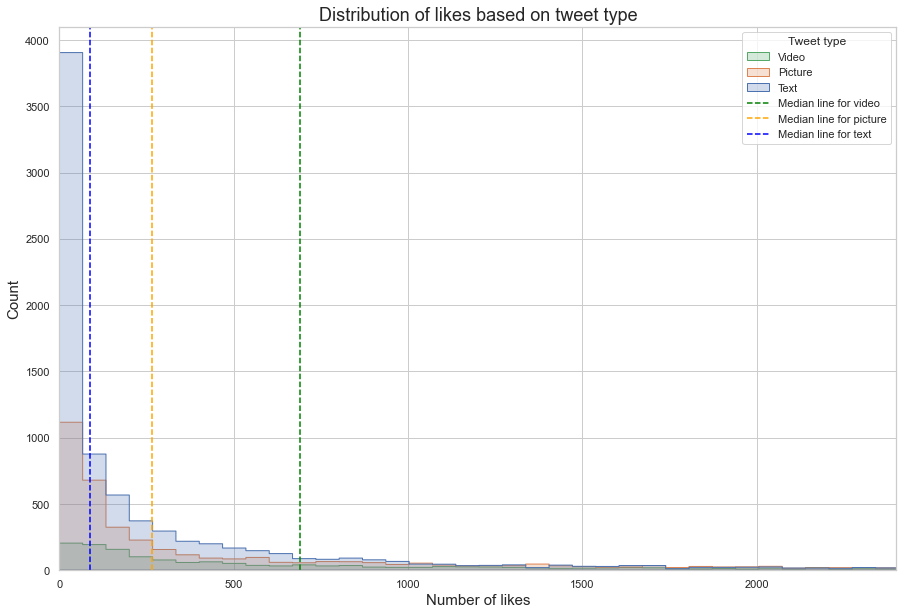

In [68]:
print('Likes statistics for pictures:')
print(round(picture['likes'].describe()))
print('--------------------------------------')
print('Likes statistics for videos:')
print(round(video['likes'].describe()))
print('--------------------------------------')
print('Likes statistics for texts:')
print(round(text['likes'].describe()))

plt.figure(figsize=(15,10))
sns.set_style('whitegrid')
sns.histplot(data = ptad, x="likes", hue="twit_type", element="step")
plt.xlim(0, 2400)

plt.xlabel("Number of likes", size=15)
plt.ylabel("Count", size=15)
plt.title("Distribution of likes based on tweet type", size=18)

plt.axvline(x=video.likes.median(),color='green',linestyle='--')
plt.axvline(x=picture.likes.median(),color='orange',linestyle='--')
plt.axvline(x=text.likes.median(),color='blue',linestyle='--')
plt.legend(title='Tweet type', loc='upper right', labels=['Video', 'Picture', 'Text', 
                                                          'Median line for video', 'Median line for picture', 'Median line for text'])

### Shares 

In [4]:
print('Shares statistics for pictures:')
print(round(picture['shares'].describe()))
print('--------------------------------------')
print('Shares statistics for videos:')
print(round(video['shares'].describe()))
print('--------------------------------------')
print('Shares statistics for texts:')
print(round(text['shares'].describe()))

plt.figure(figsize=(15,10))
sns.set_style('whitegrid')
sns.histplot(data = ptad, x="shares", hue="twit_type", element="step")
plt.xlim(0, 160)

plt.xlabel("Number of shares", size=15)
plt.ylabel("Count", size=15)
plt.title("Distribution of shares based on tweet type", size=18)

plt.axvline(x=video.shares.median(), color='green',linestyle='--')
plt.axvline(x=picture.shares.median(), color='orange',linestyle='--')
plt.axvline(x=text.shares.median(), color='blue',linestyle='--')
plt.legend(title='Tweet type', loc='upper right', labels=['Video', 'Picture', 'Text', 
                                                          'Median line for video', 'Median line for picture', 'Median line for text'])

Shares statistics for pictures:


NameError: name 'picture' is not defined

### Replies  

In [6]:
print('Replies statistics for pictures:')
print(round(picture['replies'].describe()))
print('--------------------------------------')
print('Replies statistics for videos:')
print(round(video['replies'].describe()))
print('--------------------------------------')
print('Replies statistics for texts:')
print(round(text['replies'].describe()))

plt.figure(figsize=(15,10))
sns.set_style('whitegrid')
sns.histplot(data = ptad, x="replies", hue="twit_type", element="step")
plt.xlim(0, 40)

plt.xlabel("Number of replies", size=15)
plt.ylabel("Count", size=15)
plt.title("Distribution of replies based on tweet type", size=18)

plt.axvline(x=video.replies.median(),
            color='green',linestyle='--')
plt.axvline(x=picture.replies.median(),
            color='orange',linestyle='--')
plt.axvline(x=text.replies.median(),
            color='blue',linestyle='--')
plt.legend(title='Tweet type', loc='upper right', labels=['Video', 'Picture', 'Text', 
                                                          'median line for video', 'Mean line for picture', 'Mean line for text'])

Replies statistics for pictures:


NameError: name 'picture' is not defined

### Engagement rate  

Engagement statistics for pictures:
count   4684.0000
mean       0.0014
std        0.0045
min        0.0000
25%        0.0001
50%        0.0003
75%        0.0012
max        0.1242
Name: engagement_rate, dtype: float64
--------------------------------------
Engagement statistics for videos:
count   1987.0000
mean       0.0018
std        0.0040
min        0.0000
25%        0.0002
50%        0.0006
75%        0.0016
max        0.0579
Name: engagement_rate, dtype: float64
--------------------------------------
Engagement statistics for texts:
count   8456.0000
mean       0.0006
std        0.0017
min        0.0000
25%        0.0000
50%        0.0001
75%        0.0004
max        0.0677
Name: engagement_rate, dtype: float64


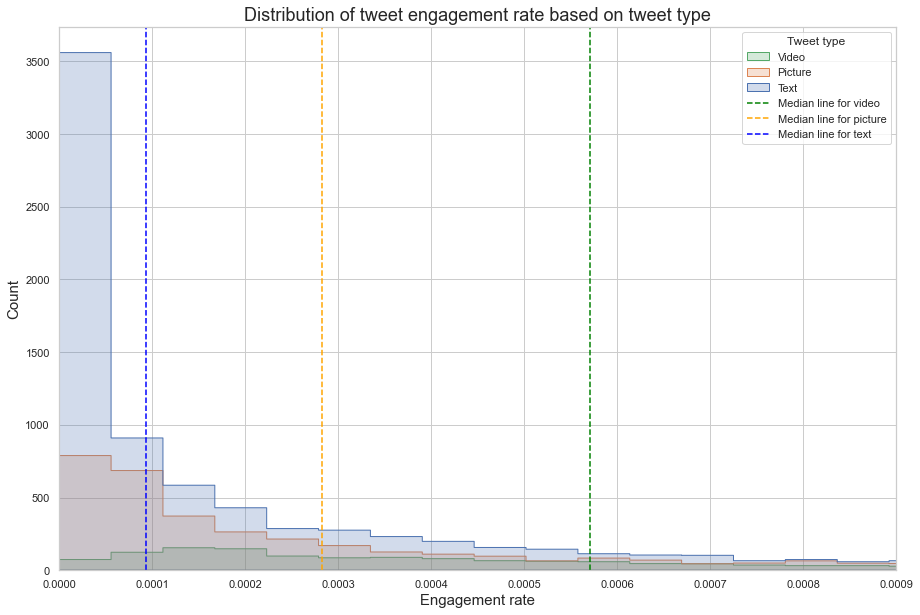

In [53]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

print('Engagement statistics for pictures:')
print(picture['engagement_rate'].describe())
print('--------------------------------------')
print('Engagement statistics for videos:')
print(video['engagement_rate'].describe())
print('--------------------------------------')
print('Engagement statistics for texts:')
print(text['engagement_rate'].describe())

plt.figure(figsize=(15,10))
sns.set_style('whitegrid')
sns.histplot(data = ptad, x="engagement_rate", hue="twit_type", element="step")
plt.xlim(0, 0.0009)

plt.xlabel("Engagement rate", size=15)
plt.ylabel("Count", size=15)
plt.title("Distribution of tweet engagement rate based on tweet type", size=18)

plt.axvline(x=video.engagement_rate.median(),
            color='green',linestyle='--')
plt.axvline(x=picture.engagement_rate.median(),
            color='orange',linestyle='--')
plt.axvline(x=text.engagement_rate.median(),
            color='blue',linestyle='--')
plt.legend(title='Tweet type', loc='upper right', labels=['Video', 'Picture', 'Text', 
                                                          'Median line for video', 'Median line for picture', 'Median line for text'])

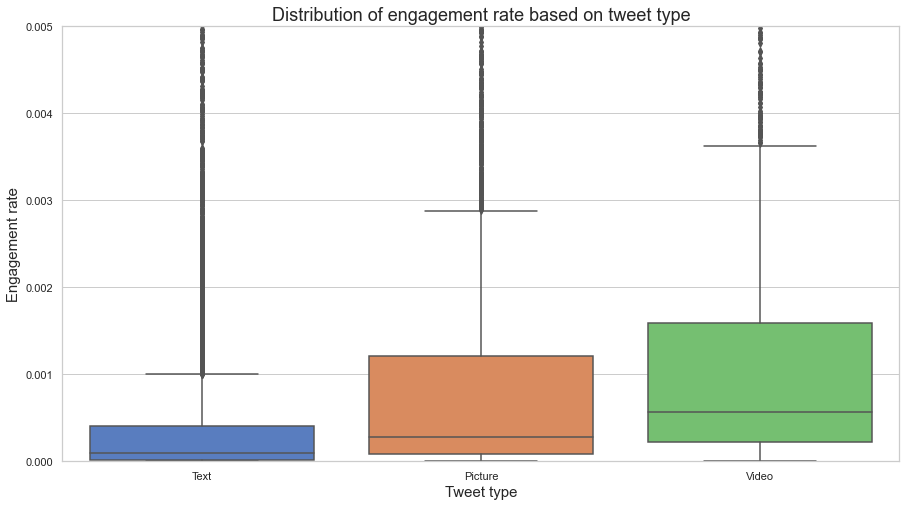

In [56]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 8))
sns.boxplot(x='twit_type', y='engagement_rate', data=ptad[ptad['twit_type'].isin(ptad['twit_type'])], palette="muted", ax =ax)
ax.set_ylim([0, 0.005])
plt.xlabel("Tweet type", size=15)
plt.ylabel("Engagement rate", size=15)
plt.title("Distribution of engagement rate based on tweet type", size=18)
plt.show()

From the plots above, we can see that videos generate most impressions, shares, likes, and have highest engagement rate. On the other hand text tweets are not so popular like videos. Moreover, we have huge number of outliers in every tweet type. If we look at the distribution of tweet views we will can see that the mean for videos is  
279772 and 75% of the data lies around 245262 however its max view number is around 5mln. 

Another question that I am interested in is the number of impressions, likes, shares, replies is correlated with the engagement rate ratio. We should think that this is the case as more popular videos tend to have more more impressions, likes, shares, and engagement rate. Let us find out.

Impression and engagement correlation:
                 impressions  engagement_rate
impressions           1.0000           0.5602
engagement_rate       0.5602           1.0000
-----------------------------------------------
Likes and impressions correlation:
             likes  impressions
likes       1.0000       0.8830
impressions 0.8830       1.0000
-----------------------------------------------
Shares and impressions correlation:
             shares  impressions
shares       1.0000       0.6364
impressions  0.6364       1.0000
-----------------------------------------------
Replies and impressions correlation:
             replies  impressions
replies       1.0000       0.4376
impressions   0.4376       1.0000
-----------------------------------------------


Text(0.5, 1.0, 'Does the number of impressions impact engagement rate?')

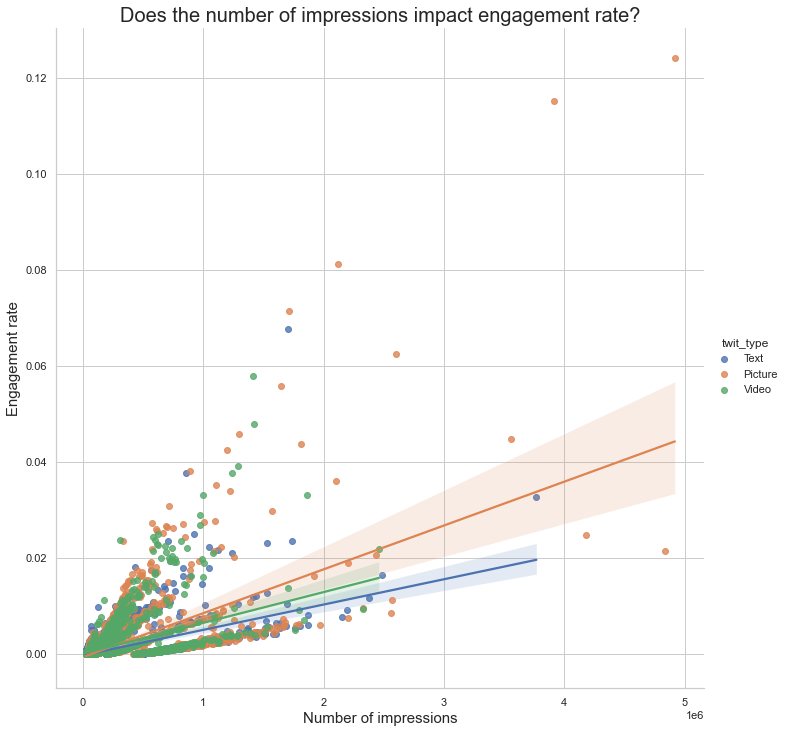

In [71]:
#Language and Views
print("Impression and engagement correlation:")
cor1 = ptad[['impressions', 'engagement_rate']]
cor_mat1=cor1.corr()
print(cor_mat1)
print('-----------------------------------------------')
print("Likes and impressions correlation:")
cor2 = ptad[['likes', 'impressions']]
cor_mat2=cor2.corr()
print(cor_mat2)
print('-----------------------------------------------')
print("Shares and impressions correlation:")
cor3 = text[['shares', 'impressions']]
cor_mat3=cor3.corr()
print(cor_mat3)
print('-----------------------------------------------')
print("Replies and impressions correlation:")
cor4 = text[['replies', 'impressions']]
cor_mat4=cor4.corr()
print(cor_mat4)
print('-----------------------------------------------')


sns.lmplot(x="impressions", 
           y="engagement_rate", 
           hue="twit_type",
           data=ptad,
           height=10)
plt.xlabel("Number of impressions", size = 15)
plt.ylabel("Engagement rate", size =15)
plt.title("Does the number of impressions impact engagement rate?", size=20)


Text(0.5, 1.0, 'Does the number of likes impact impressions')

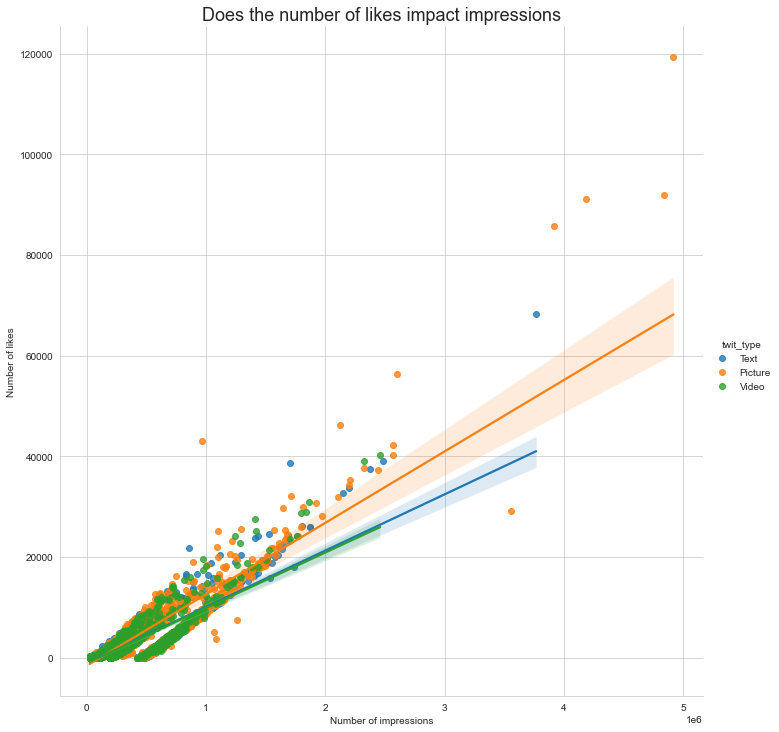

In [26]:
sns.lmplot(x="impressions", 
           y="likes", 
           hue="twit_type",
           data=ptad,
           height=10)
plt.xlabel("Number of impressions")
plt.ylabel("Number of likes")
plt.title("Does the number of likes impact impressions", size=18)


Text(0.5, 1.0, 'Does the number of shares impact impressions')

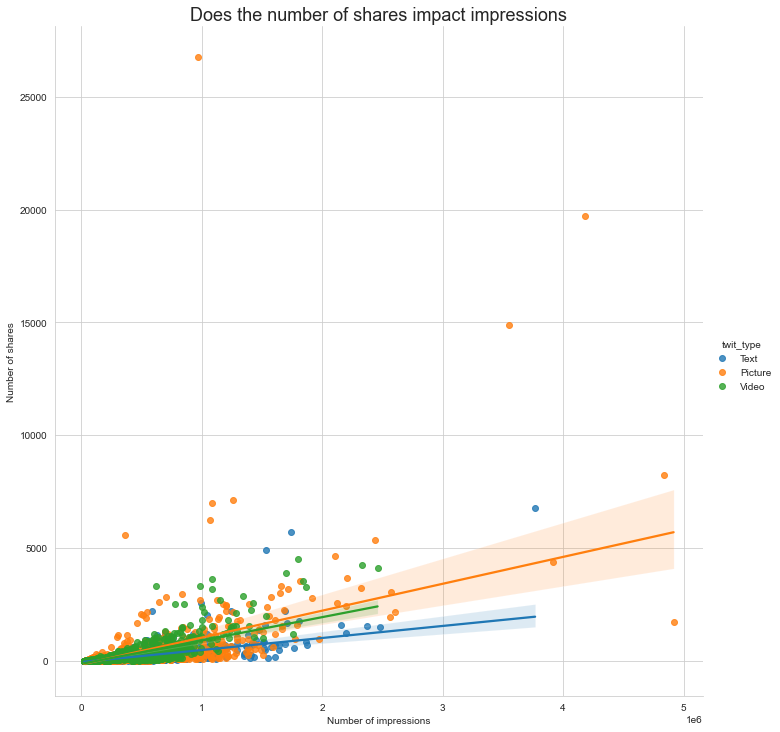

In [27]:
sns.lmplot(x="impressions", 
           y="shares", 
           hue="twit_type",
           data=ptad,
           height=10)
plt.xlabel("Number of impressions")
plt.ylabel("Number of shares")
plt.title("Does the number of shares impact impressions", size=18)

Text(0.5, 1.0, 'Does the number of replies impact impressions')

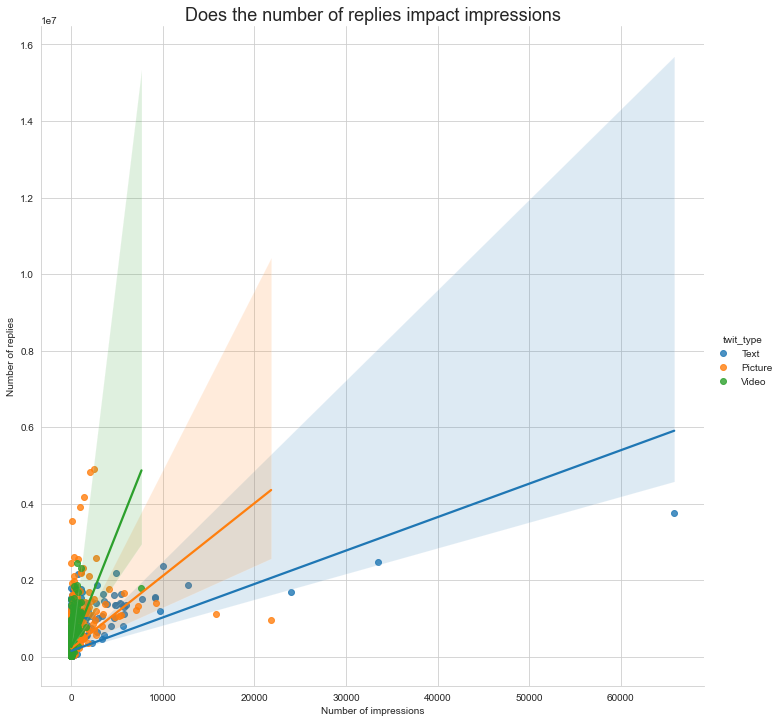

In [28]:
sns.lmplot(x="replies", 
           y="impressions", 
           hue="twit_type",
           data=ptad,
           height=10)
plt.xlabel("Number of impressions")
plt.ylabel("Number of replies")
plt.title("Does the number of replies impact impressions", size=18)

As the scatterplot and the correlation matrix show, the pearson coefficient is more than 0.5 for correlation of impressions with likes and shares, and correlation of impressions with engagement rate. This suggests a medium to strong correlation between the two quantities. This result was pretty expected as mentioned above. 

We can conlcude from these analysis that more Impressions will cause higher likes, shares and replies,and engagement rate. 

Thus impressions and engagement rate is highly correlated let's run our linear regression model to see the relationship of impressions and engagement rate with different type of tweets 

## Regressional Analytics - StatsModel

In [7]:
#our engagement rate is low and we used normalization and multiplied by 10000 to get clearer analysis 
xvar = ptad[['impressions','dummy_picture', 'dummy_video', 'dummy_text']]
yvar = ptad[['engagement_rate']]
xvar2 = sm.add_constant(xvar)
linearmoderl1 = sm.OLS(yvar, xvar2).fit()
print(linearmoderl1.summary())

NameError: name 'ptad' is not defined

In [30]:
xvar2 = ptad[['likes','shares','dummy_picture', 'dummy_video', 'dummy_text']]
yvar = ptad[['impressions']]
xvar2 = sm.add_constant(xvar2)
linearmoderl2 = sm.OLS(yvar, xvar2).fit()
print(linearmoderl2.summary())

                            OLS Regression Results                            
Dep. Variable:            impressions   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                 1.367e+04
Date:                Sun, 06 Nov 2022   Prob (F-statistic):               0.00
Time:                        16:23:20   Log-Likelihood:            -1.9724e+05
No. Observations:               15127   AIC:                         3.945e+05
Df Residuals:                   15122   BIC:                         3.945e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          9.914e+04    858.214    115.514

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


From our analysis we can make an assumption that videos are doing better which supports our previous conclusion 

## Analysing data by the day of the week and hour

Tweets has date collumn which will be helpful to analyse and know which day of the week tweets are generating higher engagement rate and impressions. Is there a hot day throughout the week or hot time during the day as far as our data is concerned?

### Best time to post a tweet

Text(0.5, 1.0, 'What time of the day is best for posting tweets?')

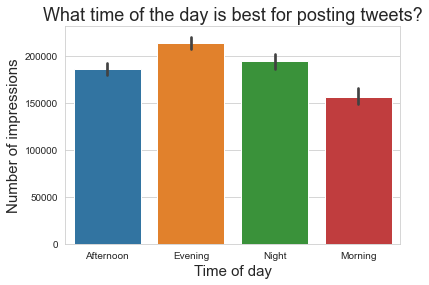

In [31]:
bar_chart = ptad[['time_of_day', 'twit_type', 'impressions', 'engagement_rate']]
sns.barplot(x='time_of_day', y='impressions', data=bar_chart)
plt.xlabel("Time of day", size=15)
plt.ylabel("Number of impressions", size=15)
plt.title("What time of the day is best for posting tweets?", size=18)

In [8]:
bar_chart = ptad[['time_of_day', 'twit_type', 'impressions', 'engagement_rate']]
sns.barplot(x='time_of_day', y='engagement_rate', data=bar_chart)
plt.xlabel("Time of day", size=15)
plt.ylabel("Engagement rate", size=15)
plt.title("What time of the day is best for posting tweets?", size=18)

NameError: name 'ptad' is not defined

Text(0.5, 1.0, 'What time of the day is best for posting tweets?')

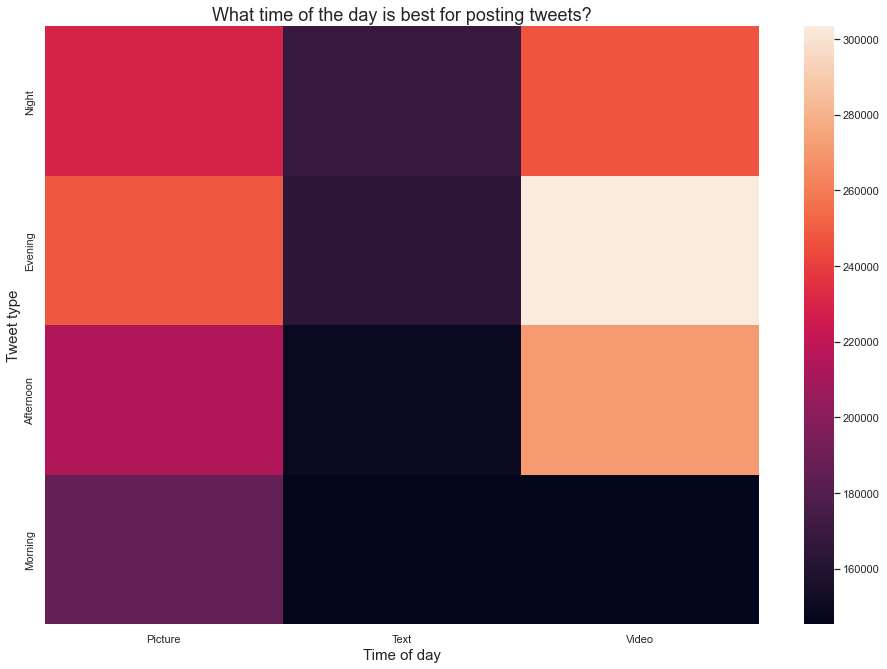

In [33]:
##Heatmap
#changing ccollumns
heatmap = ptad[['date', 'hour', 'day_of_the_week','time_of_day', 'twit_type', 'followers','video_duration_secs', 'impressions', 'likes', 'shares', 
            'replies', 'engagement_rate']]

hmap_df = heatmap[['twit_type', 'time_of_day', 'impressions']]
data_heatmap = hmap_df.pivot_table(values = "impressions",index = "time_of_day", columns = "twit_type")

data_heatmap.index = pd.CategoricalIndex(data_heatmap.index, categories= ["Night", "Evening", "Afternoon", "Morning"])
data_heatmap.sort_index(level=0, inplace=True)

sns.set(rc = {'figure.figsize':(16,11)})
sns.heatmap(data_heatmap)
plt.xlabel("Time of day", size=15)
plt.ylabel("Tweet type", size=15)
plt.title("What time of the day is best for posting tweets?", size=18)


Text(0.5, 1.0, 'What time of the day is best for posting tweets?')

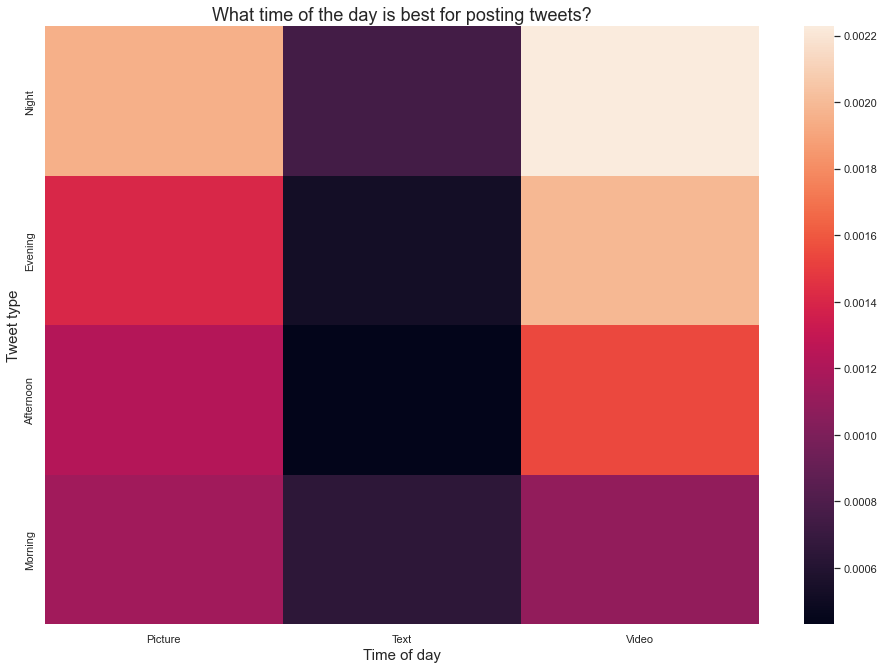

In [34]:
##Heatmap
#changing ccollumns
heatmap = ptad[['date', 'hour', 'day_of_the_week','time_of_day', 'twit_type', 'followers','video_duration_secs', 'impressions', 'likes', 'shares', 
            'replies', 'engagement_rate']]

hmap_df = heatmap[['twit_type', 'time_of_day', 'engagement_rate']]
data_heatmap = hmap_df.pivot_table(values = "engagement_rate",index = "time_of_day", columns = "twit_type")

data_heatmap.index = pd.CategoricalIndex(data_heatmap.index, categories= ["Night", "Evening", "Afternoon", "Morning"])
data_heatmap.sort_index(level=0, inplace=True)

sns.set(rc = {'figure.figsize':(16,11)})
sns.heatmap(data_heatmap)
plt.xlabel("Time of day", size=15)
plt.ylabel("Tweet type", size=15)
plt.title("What time of the day is best for posting tweets?", size=18)

Text(0.5, 1.0, 'What day of the week is best for posting tweets?')

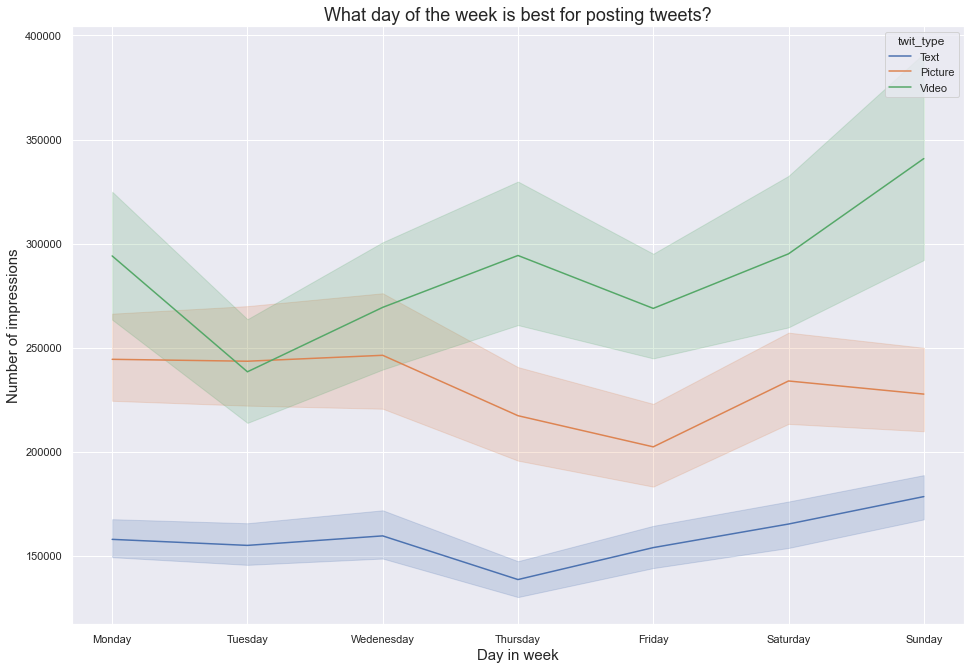

In [35]:
ptad['day_of_the_week'] = pd.Categorical(ptad['day_of_the_week'],
                                   categories=['Monday', 'Tuesday', 'Wedenesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                                   ordered=True)

sns.lineplot(data=ptad, x="day_of_the_week", y="impressions", hue = "twit_type")

plt.xlabel("Day in week", size=15)
plt.ylabel("Number of impressions", size=15)
plt.title("What day of the week is best for posting tweets?", size=18)

Text(0.5, 1.0, 'What day of the week is best for posting tweets?')

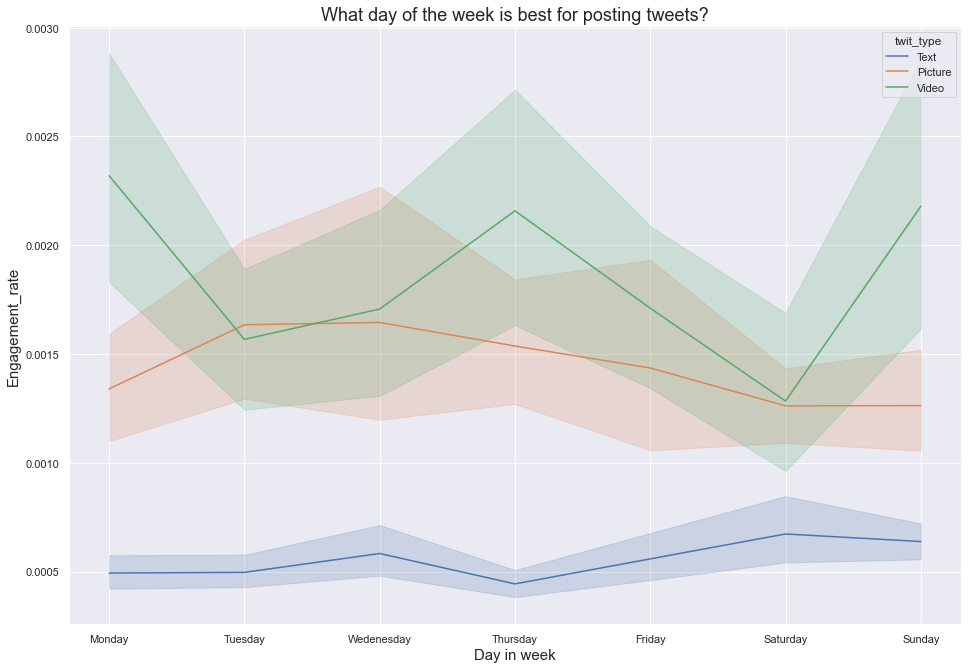

In [36]:
ptad['day_of_the_week'] = pd.Categorical(ptad['day_of_the_week'],
                                   categories=['Monday', 'Tuesday', 'Wedenesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                                   ordered=True)

sns.lineplot(data=ptad, x="day_of_the_week", y="engagement_rate", hue = "twit_type")

plt.xlabel("Day in week", size=15)
plt.ylabel("Engagement_rate", size=15)
plt.title("What day of the week is best for posting tweets?", size=18)

## Analysing videos by duration and how it impacts on our impressions and engagement ratio


Video duration:
count   1987.0000
mean      47.0000
std       78.0000
min        2.0000
25%       16.0000
50%       27.0000
75%       45.0000
max      600.0000
Name: video_duration_secs, dtype: float64


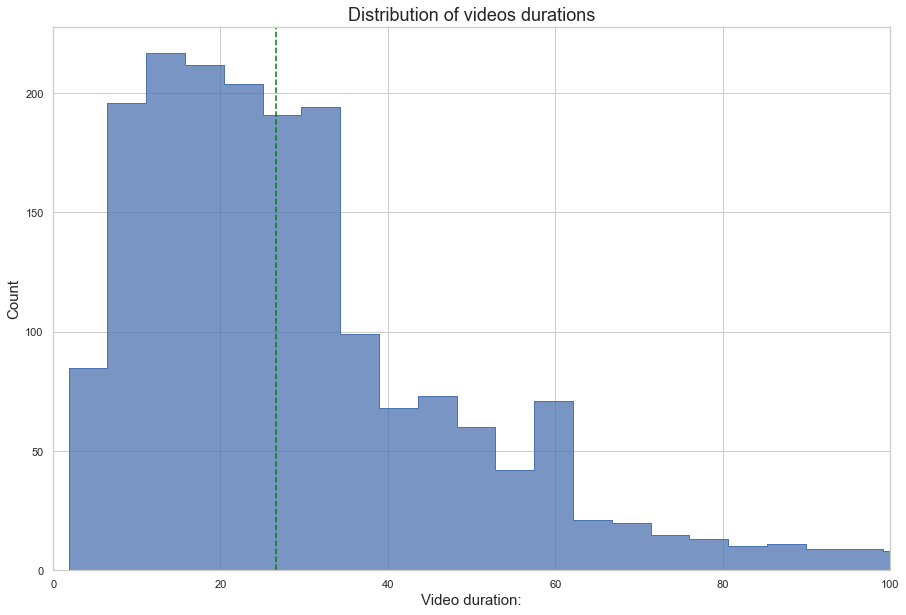

In [37]:
print('Video duration:')
print(round(video['video_duration_secs'].describe()))

plt.figure(figsize=(15,10))
sns.set_style('whitegrid')
sns.histplot(data = video, x="video_duration_secs", element="step")
plt.xlim(0, 100)

plt.xlabel("Video duration:", size=15)
plt.ylabel("Count", size=15)
plt.title("Distribution of videos durations", size=18)

plt.axvline(x=video.video_duration_secs.median(),
            color='green',linestyle='--')

Video duration and impressions correlation:
             replies  impressions
replies       1.0000       0.4376
impressions   0.4376       1.0000
-----------------------------------------------


Text(0.5, 1.0, 'Does the video duration impact impressions number')

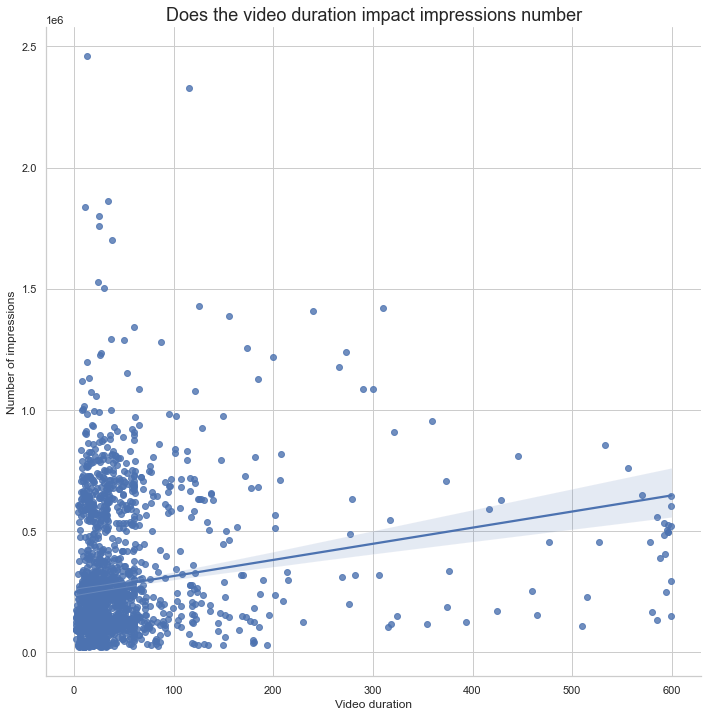

In [38]:
print("Video duration and impressions correlation:")
vd_cor = video[['video_duration_secs', 'impressions']]
vd_cor_mat=vd_cor.corr()
print(cor_mat4)
print('-----------------------------------------------')


sns.lmplot(x="video_duration_secs", 
           y="impressions", 
           data=video,
           height=10)
plt.xlabel("Video duration")
plt.ylabel("Number of impressions")
plt.title("Does the video duration impact impressions number", size=18)


Video duration and engagement rate:
             replies  impressions
replies       1.0000       0.4376
impressions   0.4376       1.0000
-----------------------------------------------


Text(0.5, 1.0, 'Does the video duration impact Engagement rate')

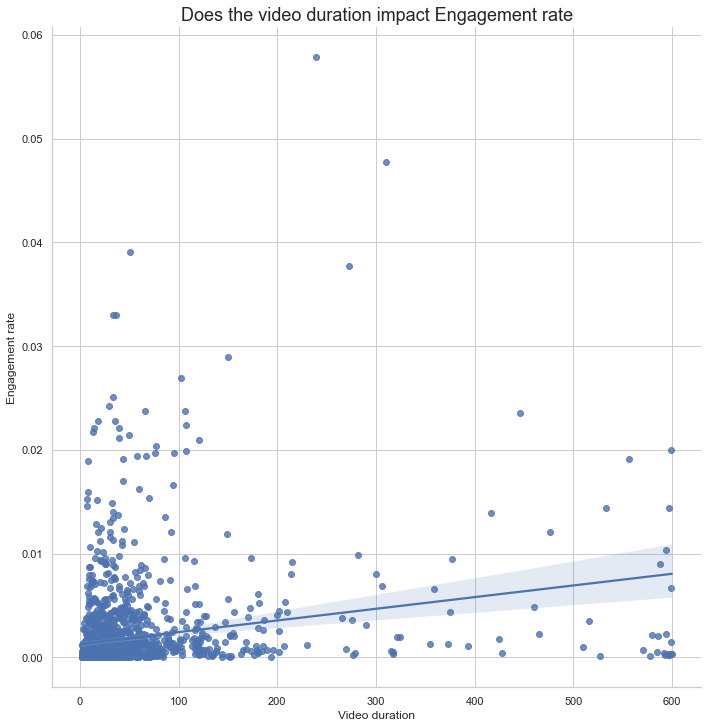

In [39]:
print("Video duration and engagement rate:")
vd_cor = video[['video_duration_secs', 'engagement_rate']]
vd_cor_mat=vd_cor.corr()
print(cor_mat4)
print('-----------------------------------------------')


sns.lmplot(x="video_duration_secs", 
           y="engagement_rate", 
           data=video,
           height=10)
plt.xlabel("Video duration")
plt.ylabel("Engagement rate")
plt.title("Does the video duration impact Engagement rate", size=18)


(0.0, 100.0)

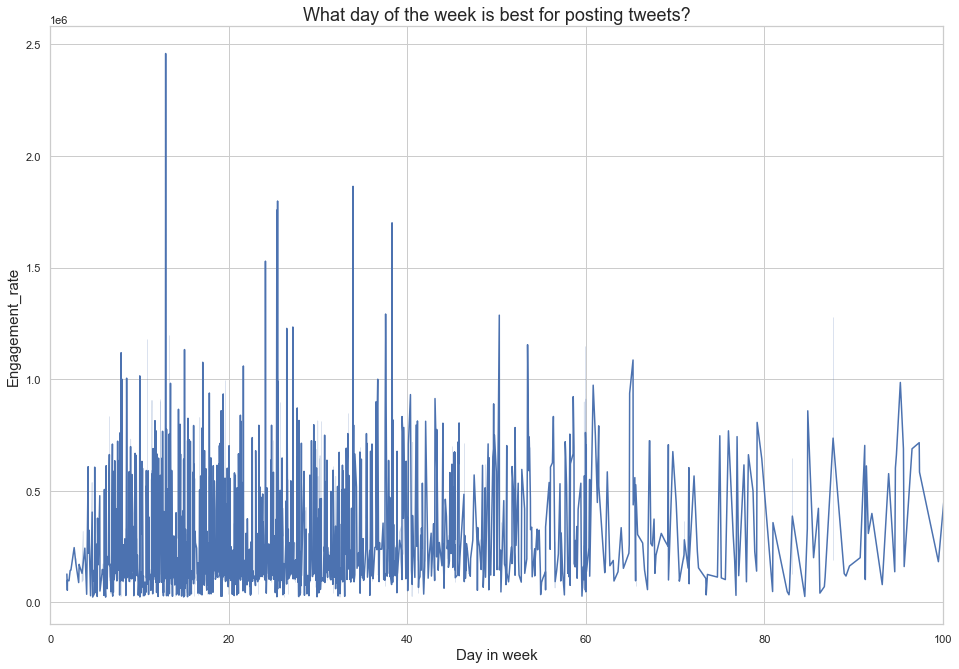

In [40]:
sns.lineplot(data=video, x="video_duration_secs", y="impressions")

plt.xlabel("Day in week", size=15)
plt.ylabel("Engagement_rate", size=15)
plt.title("What day of the week is best for posting tweets?", size=18)
plt.xlim(0,100)

## Conclusion

* Videos has the most impressions and engagement rate. Then pictures and texts come
* Regression analysis support my previous assumptions
* Impressions are directly impacting engagement rate. More number of impressions cause higher engagement rate
* 75% of videos duration is about 45 secs which means that shorter durations will have higher number of impressions and engagement rate. 
* I assume that non-followers do not usually watch longer videos
* Evenings and nights are the best time to post tweets while I suggest to avoid mornings
* In the nights people are more engaged with videos and pictures 
* Thursday is the best day to post videos while it can be a killer for texts 
* On Tuesdays and Wednesdays people tend to be more engaged with pictures 